# Lesson 29: PyTorch neural network demonstration part 1
## Notebook set-up
### Imports

In [ ]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #.  It is a platform and programming model created by NVIDIA that allows software (like PyTorch) to use the GPU 
                                                                      #   for general-purpose computation — not just graphics.In short:CUDA = using the GPU to do math fast
print(f'Using device: {device}')

Using device: cpu


## 1. Load preprocessed data

In [2]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')

training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

print(f'Training samples: {len(training_df)}')
print(f'Testing samples: {len(testing_df)}')
print(f'Features: {features}')
print(f'Label: {label}')

Training samples: 15480
Testing samples: 5160
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: MedHouseVal


In [12]:
training_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
8158,0.176489,0.666407,-0.060854,-0.281118,-0.496544,-0.048283,-0.860741,0.730999,0.185825
18368,0.771374,1.062889,0.383521,-0.020378,-0.411672,-0.058729,0.709168,-1.196710,0.630798
19197,0.021424,0.587111,0.278523,-0.084625,-0.626915,-0.072838,1.313701,-1.551288,-0.208072
3746,1.309004,0.269925,0.233072,-0.243135,-0.234928,-0.069768,-0.696721,0.586171,2.240147
13073,-0.793136,-0.919520,-0.264184,-0.139881,-0.631290,-0.085141,1.369936,-0.872096,-0.493755


In [13]:
data.keys()

dict_keys(['training_df', 'testing_df', 'features', 'label', 'feature_scaler', 'label_scaler'])

## 2. PyTorch nn.Sequential model

The `nn.Sequential` container is the simplest way to build a neural network in PyTorch. It allows you to create models layer-by-layer in a linear stack, similar to Keras Sequential API.

In [15]:
training_df[label].values

array([ 0.1858249 ,  0.63079821, -0.2080717 , ...,  0.13041967,
        0.66196365,  1.02123198])

                        What happens step by step for features:

training_df[features] --> Selects only feature columns (X) --> Shape: (num_samples, num_features)

.values --> Converts DataFrame → NumPy array

torch.tensor(...) --> Converts NumPy → PyTorch tensor

dtype=torch.float32 --> Ensures floating-point math (required for NN)

PyTorch models expect float32 --> .to(device)

Moves tensor to: --> CPU, or  GPU (cuda) if available

Result:   -- > X_train → 2D tensor [samples × features]



                       it looks slightly different for label:
                       
y_train = torch.tensor(training_df[label].values,
                       dtype=torch.float32).unsqueeze(1).to(device)

training_df[label]. --> Single column → shape (N,)

torch.tensor(..., float32) --> Converts to tensor

.unsqueeze(1) --> Converts shape: --> (N,)  →  (N, 1)


This is critical for loss functions Neural networks expect:

y_pred shape = (N, 1)
y_true shape = (N, 1)

Without unsqueeze(1) → shape mismatch error 



### 2.1. Create PyTorch Tensors

In [3]:
X_train = torch.tensor(training_df[features].values, dtype=torch.float32).to(device)
y_train = torch.tensor(training_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

X_test = torch.tensor(testing_df[features].values, dtype=torch.float32).to(device)
y_test = torch.tensor(testing_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: torch.Size([15480, 8])
y_train shape: torch.Size([15480, 1])


### 2.2 Build DNN model

In [4]:
sequential_model = nn.Sequential(
    nn.Linear(8, 32), # Similar to 'Dense' in TensorFlow
    nn.ReLU(),        # Activation function for previous layer
    nn.Dropout(0.2),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1)
).to(device)

print(sequential_model)

Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
criterion = nn.MSELoss()  # defines the loss function --> loss = criterion(y_pred, y_true) --> Measures how wrong predictions are (mean squared error)
optimizer = optim.Adam(sequential_model.parameters(), lr=1e-2) # Knows how to update weights when told to do so

In [ ]:
def train_model(
        model: nn.Sequential,
        X_train: torch.tensor,
        y_train: torch.tensor,
        criterion: nn.MSELoss,
        optimizer: optim.Adam,
        epochs: int = 100
):
    '''Training loop in PyTorch'''

    history = {'loss': []}

    for epoch in range(epochs):

        # Initialization
        model.train()
        optimizer.zero_grad() # reset gradients

        # Forward pass
        predictions = model(X_train)

        # Calculate loss
        loss = criterion(predictions, y_train)

        # Save loss in history
        history['loss'].append(loss.item())

        # Backwards pass , compute gradients , Gradients are not chosen, not tuned, not fixed.
        #  They are calculated from data + current weights, COMPUTED automatically
        # Figure out how much each weight contributed to the error, and in which direction it should change to reduce the error
        loss.backward()

        # Update weights , looks at the gradients computed by backward() , updates weights to reduce the loss
        optimizer.step()

        print(f'Epoch: {epoch}, loss: {loss.item():.4f}')

    return history

### 2.4. Train model

In [7]:
sequential_history = train_model(
    model = sequential_model,
    X_train = X_train,
    y_train = y_train,
    criterion = criterion,
    optimizer = optimizer 
)

Epoch: 0, loss: 0.9964
Epoch: 1, loss: 0.9498
Epoch: 2, loss: 0.8933
Epoch: 3, loss: 0.8182
Epoch: 4, loss: 0.7399
Epoch: 5, loss: 0.6658
Epoch: 6, loss: 0.6385
Epoch: 7, loss: 0.6365
Epoch: 8, loss: 0.5990
Epoch: 9, loss: 0.5572
Epoch: 10, loss: 0.5258
Epoch: 11, loss: 0.5103
Epoch: 12, loss: 0.4952
Epoch: 13, loss: 0.4878
Epoch: 14, loss: 0.4743
Epoch: 15, loss: 0.4597
Epoch: 16, loss: 0.4573
Epoch: 17, loss: 0.4533
Epoch: 18, loss: 0.4399
Epoch: 19, loss: 0.4301
Epoch: 20, loss: 0.4216
Epoch: 21, loss: 0.4121
Epoch: 22, loss: 0.4112
Epoch: 23, loss: 0.4113
Epoch: 24, loss: 0.3998
Epoch: 25, loss: 0.3983
Epoch: 26, loss: 0.3902
Epoch: 27, loss: 0.3843
Epoch: 28, loss: 0.3827
Epoch: 29, loss: 0.3784
Epoch: 30, loss: 0.3731
Epoch: 31, loss: 0.3693
Epoch: 32, loss: 0.3675
Epoch: 33, loss: 0.3613
Epoch: 34, loss: 0.3615
Epoch: 35, loss: 0.3621
Epoch: 36, loss: 0.3572
Epoch: 37, loss: 0.3516
Epoch: 38, loss: 0.3500
Epoch: 39, loss: 0.3465
Epoch: 40, loss: 0.3441
Epoch: 41, loss: 0.3425
Ep

### 2.5. Plot learning curves

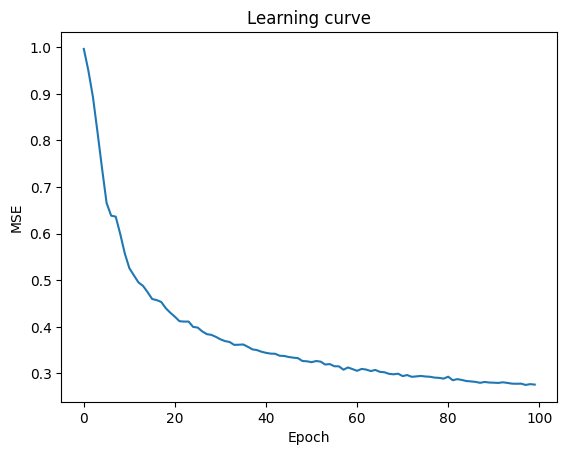

In [8]:
plt.title('Learning curve')
plt.plot(sequential_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

## 3. PyTorch nn.Module class-based model

The `nn.Module` class provides more flexibility than `nn.Sequential`. It allows you to create models via subclassing with custom forward methods, non-linear topology, shared layers, and multiple inputs or outputs, similar to the Keras Functional API.